In [1]:
from collections import defaultdict
import gym
import numpy as np
import matplotlib.pyplot as plt

## Part 1.1

In [79]:
actions = {"stick" : 0, "hit" : 1}

In [74]:
def policy(state):
    if state > 18:
        return actions["stick"]
    else:
        return actions["hit"]

In [75]:
def generate_episode(env, policy):
    state = env.reset() 

    states = []
    actions = []
    rewards = []

    done = False

    while not done:
        action = policy(state[0])

        states.append(state)
        actions.append(action)

        next_state, reward, done, _ = env.step(action)

        rewards.append(reward)

        state = next_state

    return states, actions, rewards

In [76]:
def mc_prediction_v(env, policy, num_episodes, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: 0)
    N = defaultdict(lambda: 0)
    V = defaultdict(lambda: 0)
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            
        # obtain the states, actions, and rewards
        states, actions, rewards = generate_episode(env, policy)

        discounts = np.array([gamma**i for i in range(len(rewards))]) 

        for i in range(len(rewards)):

          if i == 0:
            G_r = sum(rewards[i:] * discounts[:])
          else:
            G_r = sum(rewards[i:] * discounts[:-i])

          returns_sum[states[i]] += G_r
          N[states[i]] += 1.0
            
    V = {}
    for state in N:
        V[state] = returns_sum[state] / N[state]
    return V

In [77]:
env = gym.make('Blackjack-v0', natural=True)
V = mc_prediction_v(env, policy, 100000, gamma=1.0)

Episode 100000/100000.

In [78]:
V[(20, 5, False)]

0.6523545706371191

## Part 1.2-3 MC control

In [106]:
def conduct_experiments_pi(env, policy, Q, num_experiments=100000):
    num_steps, total_reward = [], []
    for i in range(num_experiments):
        state = env.reset()
        total_reward.append(0)
        
        done = False
        
        while not done:
            state, reward, done, _ = env.step(policy(-1, env.action_space.n, Q[state]))
            total_reward[-1] += reward

    env.close()
    return np.sum(total_reward)

In [107]:
def policy_with_eps(eps, action_space, Q_for_state):
  if np.random.rand() > eps: 
    return np.random.choice(np.where(Q_for_state == np.max(Q_for_state))[0])
  else: 
    return np.random.randint(action_space)

In [145]:
def generate_episode_for_alg(env, policy, Q, epsilon):
    states = []
    actions = []
    rewards = []
    state = env.reset() 

    done = False
 
    while not done:
        states.append(state)
      
        action = policy(epsilon, env.action_space.n,  Q[state])
        actions.append(action)

        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        state = next_state

    return states, actions, rewards

In [109]:
def mc_control(env, Q, policy, gamma, alpha, epsilon):
  
  states, actions, rewards =  generate_episode_for_alg(env, policy, Q, epsilon)   
  G = 0

  for i in range(len(rewards))[::-1]:
    G = gamma * G + rewards[i]
                
    Q[states[i]][actions[i]] += alpha * (G - Q[states[i]][actions[i]])

  return Q

In [133]:
def exp_with_results_mc(env, Q_arr_creation_func, total_episodes, exp_freq, gamma, alpha, epsilon):
  results_Qlearn = []

  Q_arr = defaultdict(lambda: np.zeros(env.action_space.n))

  for n in range(0, total_episodes + 1):
      Q_arr = Q_arr_creation_func(env, Q_arr, policy_with_eps, gamma, alpha, epsilon)

      if n % exp_freq == 0:
          print("\rEpisode {}/{}.".format(n, total_episodes), end="")
          result = conduct_experiments_pi(env, policy_with_eps, Q_arr)
          results_Qlearn.append(result)

  env.close()
  return results_Qlearn

In [162]:
num_exp = 4

total_episodes = 100000
exp_freq = 25000
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.1

res_rewards = [exp_with_results_mc(env, mc_control, total_episodes, exp_freq, gamma, alpha, epsilon) for i in range(num_exp)]

Episode 100000/100000.

last reward:-5078.25


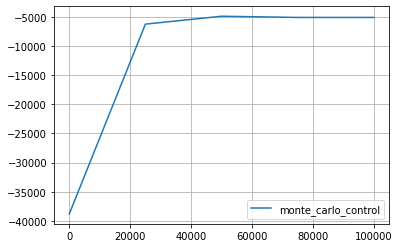

In [165]:
print("last reward:" + str(np.mean(res_rewards, axis = 0)[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), np.mean(res_rewards, axis = 0), label="monte_carlo_control")
plt.grid()
_ = plt.legend()
plt.show()

In [178]:
num_exp = 4

total_episodes = 100000
exp_freq = 25000
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.99
alpha = 0.1
epsilon = 0.4

res_rewards = [exp_with_results_mc(env, mc_control, total_episodes, exp_freq, gamma, alpha, epsilon) for i in range(num_exp)]

Episode 100000/100000.

last reward:-7156.0


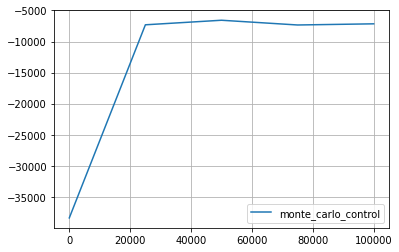

In [179]:
print("last reward:" + str(np.mean(res_rewards, axis = 0)[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), np.mean(res_rewards, axis = 0), label="monte_carlo_control")
plt.grid()
_ = plt.legend()
plt.show()

## Part 1.2-3 Q learning

In [173]:
def Q_step(env, Q, policy, gamma, alpha, epsilon):
    curr_state = env.reset()

    done = False

    while not done:   

            curr_act = policy(epsilon, env.action_space.n,  Q[curr_state])
            next_state, reward, done, _ = env.step(curr_act)
            
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[curr_state][curr_act])
            curr_state = next_state
    return Q

In [184]:
num_exp = 4

total_episodes = 100000
exp_freq = 25000
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.1

res_rewards = [exp_with_results_mc(env, Q_step, total_episodes, exp_freq, gamma, alpha, epsilon) for i in range(num_exp)]

Episode 100000/100000.

last reward:-13932.625


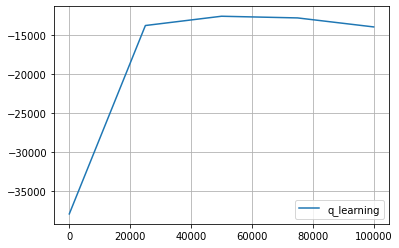

In [185]:
print("last reward:" + str(np.mean(res_rewards, axis = 0)[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), np.mean(res_rewards, axis = 0), label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

In [187]:
num_exp = 4

total_episodes = 100000
exp_freq = 25000
env = gym.make('Blackjack-v0', natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.3

res_rewards = [exp_with_results_mc(env, Q_step, total_episodes, exp_freq, gamma, alpha, epsilon) for i in range(num_exp)]

Episode 100000/100000.

last reward:-11492.125


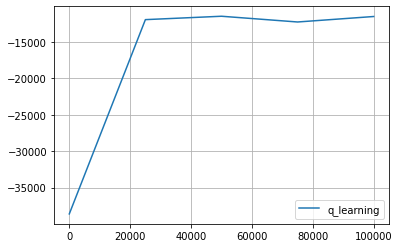

In [188]:
print("last reward:" + str(np.mean(res_rewards, axis = 0)[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), np.mean(res_rewards, axis = 0), label="q_learning")
plt.grid()
_ = plt.legend()
plt.show()

## Part 2

In [199]:
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvWithDouble(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        if action == 2:

            done = True

            self.player.append(draw_card(self.np_random))

            if is_bust(self.player):
                reward = -1 * 2.

            else:
                while sum_hand(self.dealer) < 17:
                  self.dealer.append(draw_card(self.np_random))
                
                reward = 2 * cmp(score(self.player), score(self.dealer))

        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))

            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.

        else:  # stick: play out the dealers hand, and score
            done = True

            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))

            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5


        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [204]:
num_exp = 4

total_episodes = 200000
exp_freq = 25000
env = BlackjackEnvWithDouble(natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.05

res_rewards = [exp_with_results_mc(env, mc_control, total_episodes, exp_freq, gamma, alpha, epsilon) for i in range(num_exp)]

Episode 200000/200000.

last reward:-4037.5


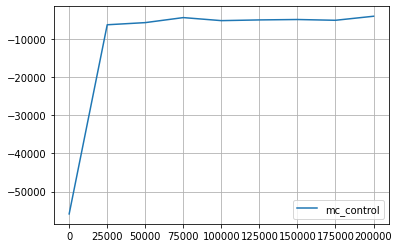

In [205]:
print("last reward:" + str(np.mean(res_rewards, axis = 0)[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), np.mean(res_rewards, axis = 0), label="mc_control")
plt.grid()
_ = plt.legend()
plt.show()

## Part 3

In [214]:
score_for_card = {2:1, 3:1, 4:1, 5:1, 6:1, 7:0, 8:0, 9:0, 10:-1, 1:-1}
initial_deck_state = {1:4, 2:4, 3:4, 5:4, 6:4, 7:4, 8:4, 9:4, 10:16}

def cmp(a, b):
    return float(a > b) - float(a < b)

def count_score(current_state, card):
    total = 0
    for i in card:
      total += score_for_card[i]
    
    return current_state + total

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnvWithDoubleAndCounts(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(21),
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.card_count = 0
        self.deck_current_state = initial_deck_state.copy()
        self.card_number = 48
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return

          card = self.draw_card_for_counts(self.np_random)
          self.card_count = count_score(self.card_count, [card])
          self.player.append(card)
            
          if is_bust(self.player):
            done = True
            reward = -1.
          else:
            done = False
            reward = 0.

        elif action == 0:  # stick: play out the dealers hand, and score
          done = True

          while sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw_card_for_counts(self.np_random))

          self.card_count = count_score(self.card_count, self.dealer[1:])
          reward = cmp(score(self.player), score(self.dealer))

          if self.natural and is_natural(self.player) and reward == 1.:
            reward = 1.5

        elif action == 2: # double

          done = True

          card = self.draw_card_for_counts(self.np_random)
          self.card_count = count_score(self.card_count, [card])
          self.player.append(card)

          while sum_hand(self.dealer) < 17:
            self.dealer.append(draw_card(self.np_random))
                
          self.card_count = count_score(self.card_count, self.dealer[1:])

          reward = 2 * cmp(score(self.player), score(self.dealer))

        return self._get_obs(), reward, done, {}



    def draw_hand_for_counts(self, np_random):
        return [self.draw_card_for_counts(np_random), self.draw_card_for_counts(np_random)]

    def draw_card_for_counts(self, np_random):
        if self.card_number < 15:
          self.card_number = 48
          self.deck_current_state = initial_deck_state.copy()
          self.card_count = 0
        
        received_card = int(np_random.choice(list(self.deck_current_state.keys()), p = np.array(list(self.deck_current_state.values())) / self.card_number))
        self.card_number -= 1
        self.deck_current_state[received_card] -= 1
        return received_card


    def _get_obs(self):
        return (self.card_count, sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = self.draw_hand_for_counts(self.np_random)
        self.player = self.draw_hand_for_counts(self.np_random)
        self.card_count = count_score(self.card_count, self.player)
        self.card_count = count_score(self.card_count, [self.dealer[0]])
        return self._get_obs()

In [217]:
total_episodes = 500000
exp_freq = 25000
env = BlackjackEnvWithDoubleAndCounts(natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.2

res_reward = exp_with_results_mc(env, mc_control, total_episodes, exp_freq, gamma, alpha, epsilon)

Episode 500000/500000.

last reward:-3969.0


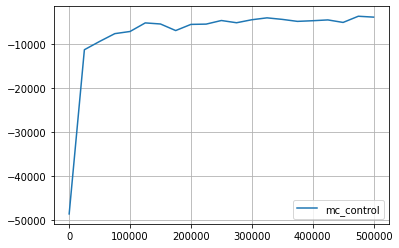

In [218]:
print("last reward:" + str(res_reward[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), res_reward, label="mc_control")
plt.grid()
_ = plt.legend()
plt.show()

In [219]:
total_episodes = 500000
exp_freq = 25000
env = BlackjackEnvWithDoubleAndCounts(natural=True)
gamma = 0.9
alpha = 0.1
epsilon = 0.1

res_reward = exp_with_results_mc(env, mc_control, total_episodes, exp_freq, gamma, alpha, epsilon)

Episode 500000/500000.

last reward:-3140.5


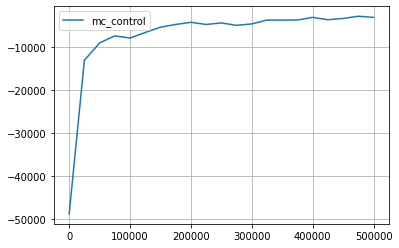

In [220]:
print("last reward:" + str(res_reward[-1]))
plt.plot(np.arange(0, total_episodes + 1, exp_freq), res_reward, label="mc_control")
plt.grid()
_ = plt.legend()
plt.show()